# LSTM相关性预测

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import datetime
%matplotlib inline

## 读取波动率序列

In [90]:
np.random.seed(1234)
seq_len = 20

In [147]:
fname = '../../risk parity portfolio/data/assets.xlsx'
df = pd.read_excel(fname)
# df.sort_index(inplace=True, ascending=False)
vec = df['AU9999.SGE'].pct_change().rolling(window=243).corr(df['CBA00101.CS'].pct_change())
vec = vec[vec.index >= '2009-01-01']
vec.tail()

2018-11-01    0.125412
2018-11-02    0.127592
2018-11-05    0.128602
2018-11-06    0.133031
2018-11-07    0.134312
dtype: float64

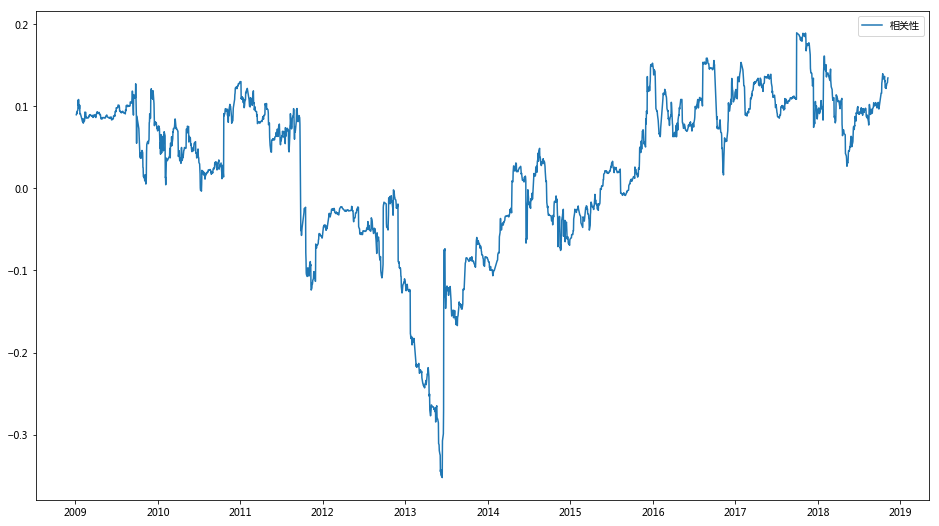

In [148]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(vec, label=u'相关性')
ax.legend()

## 将序列转成矩阵
横坐标是样本点的个数，纵坐标是窗口大小

In [149]:
def series2matrix(vec, seq_len):
    matrix = []
    for i in range(vec.size - seq_len + 1):
        matrix.append(vec[i : i+seq_len])
    return np.array(matrix)

In [150]:
mat = series2matrix(vec, seq_len)

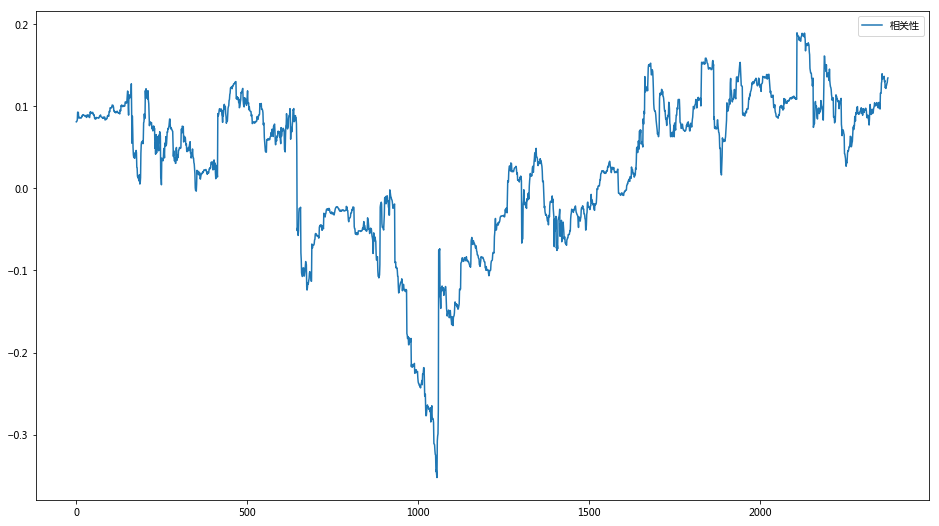

In [151]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(mat[:, -1], label=u'相关性')
ax.legend()

## 序列预处理

In [152]:
# shift all data by mean
# shifted_value = mat.mean()
# mat -= shifted_value

## 得到训练和测试样本

In [153]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(0.9 * mat.shape[0]))
train_set = mat[:train_row, :].copy()
train_mean = train_set.mean(axis=1).reshape(-1, 1).copy()
train_set -= train_mean
test_set = mat[train_row:, :].copy()
test_mean = test_set.mean(axis=1).reshape(-1, 1).copy()
test_set -= test_mean

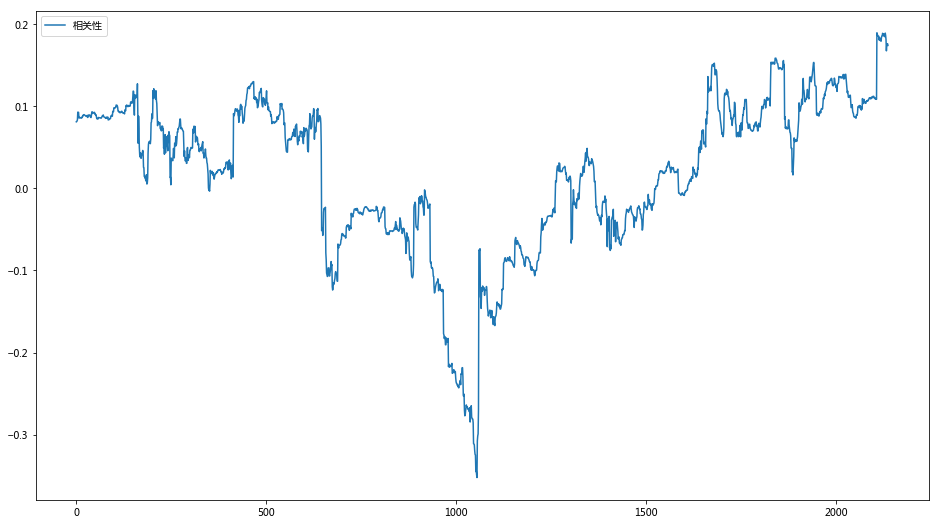

In [154]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((train_set + train_mean)[:, -1], label=u'相关性')
# ax.plot((test_set + test_mean)[:, -1], label=u'波动率')
ax.legend()

In [155]:
# shuffle the training set (but do not shuffle the test set)
np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [156]:
# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [157]:
print(X_train.shape)
print(X_test.shape)

(2138, 19, 1)
(237, 19, 1)


## 构建模型

In [158]:
# build the model
model = Sequential()

In [159]:
# layer 1: LSTM
model.add(LSTM(input_shape=(None,1), units=50, return_sequences=True))
model.add(Dropout(0.2))

In [160]:
# layer 2: LSTM
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

In [161]:
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(units=1, activation='linear'))

In [162]:
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

## 训练模型

In [163]:
# train the model
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.05, verbose=1)

Train on 2031 samples, validate on 107 samples
Epoch 1/50
2031/2031 [==============================] - 2s 1ms/step - loss: 9.1351e-04 - val_loss: 3.6699e-04
Epoch 2/50
2031/2031 [==============================] - 0s 222us/step - loss: 4.7470e-04 - val_loss: 3.3164e-04
Epoch 3/50
2031/2031 [==============================] - 0s 219us/step - loss: 4.3931e-04 - val_loss: 2.8543e-04
Epoch 4/50
2031/2031 [==============================] - 0s 219us/step - loss: 3.8336e-04 - val_loss: 2.4464e-04
Epoch 5/50
2031/2031 [==============================] - 0s 218us/step - loss: 4.1503e-04 - val_loss: 4.3610e-04
Epoch 6/50
2031/2031 [==============================] - 0s 220us/step - loss: 3.5589e-04 - val_loss: 1.6051e-04
Epoch 7/50
2031/2031 [==============================] - 0s 220us/step - loss: 2.4723e-04 - val_loss: 2.9378e-04
Epoch 8/50
2031/2031 [==============================] - 0s 222us/step - loss: 3.2914e-04 - val_loss: 1.4316e-04
Epoch 9/50
2031/2031 [==============================] - 0s 

In [164]:
# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

237/237 [==============================] - 0s 249us/step

The mean squared error (MSE) on the test data set is 0.000 over 237 test samples.


## 测试集验证

In [165]:
# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

In [166]:
predicted_values = pd.Series(predicted_values[:, 0], index=vec.index[train_row+seq_len-1:])

In [167]:
true_values = pd.Series(y_test, index=vec.index[train_row+seq_len-1:])

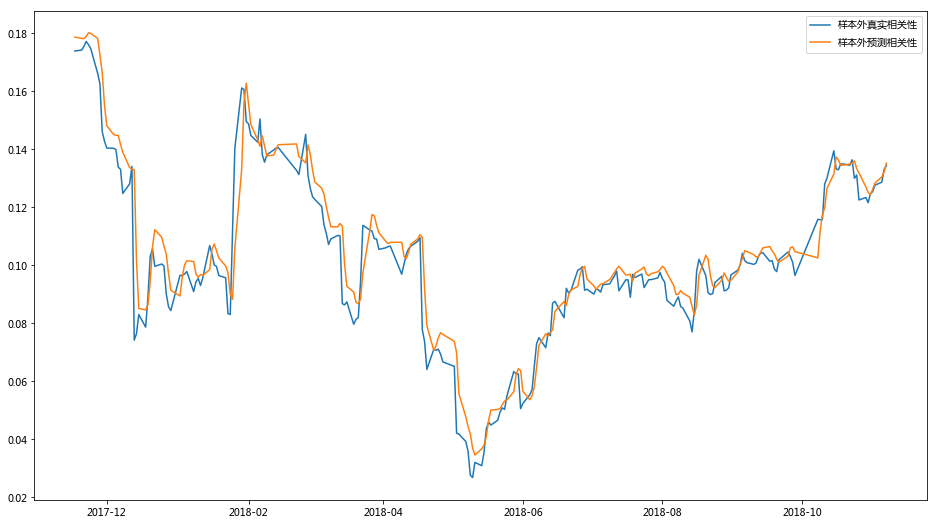

In [168]:
# plot the results
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(true_values + test_mean.reshape(-1), label=u'样本外真实相关性')
ax.plot(predicted_values + test_mean.reshape(-1), label=u'样本外预测相关性')
ax.legend()

## 未来相关性预测

In [169]:
# fut_vec = vec[-seq_len:].tolist()
# fut_vec = (predicted_values + shifted_value)[-seq_len:].tolist()
fut_vec = (predicted_values + test_mean.reshape(-1))[-seq_len:].tolist()
fut_len = 10

In [170]:
for i in range(fut_len):
    pred_vec = np.array(fut_vec[-seq_len+1:])
    matrix = pred_vec - pred_vec.mean()
#     matrix -= shifted_value
    matrix = np.reshape(matrix, (1, seq_len-1, 1))
    pred = model.predict(matrix)
    print(pred[0][0] + pred_vec.mean())
    fut_vec.append(pred[0][0] + pred_vec.mean())
#     print(pred[0][0])

0.13731624707553042
0.1394138360536755
0.14123588944129947
0.1427408529453834
0.14401827082257815
0.1451302823461454
0.1461091596477855
0.14698667042924604
0.14778499897591602
0.14850439699752363


In [171]:
dates = [vec.index[-1] + datetime.timedelta(i) for i in range(0, fut_len + 1)]

In [172]:
fut_seq = pd.Series(fut_vec[-(fut_len+1):], index=pd.to_datetime(dates))

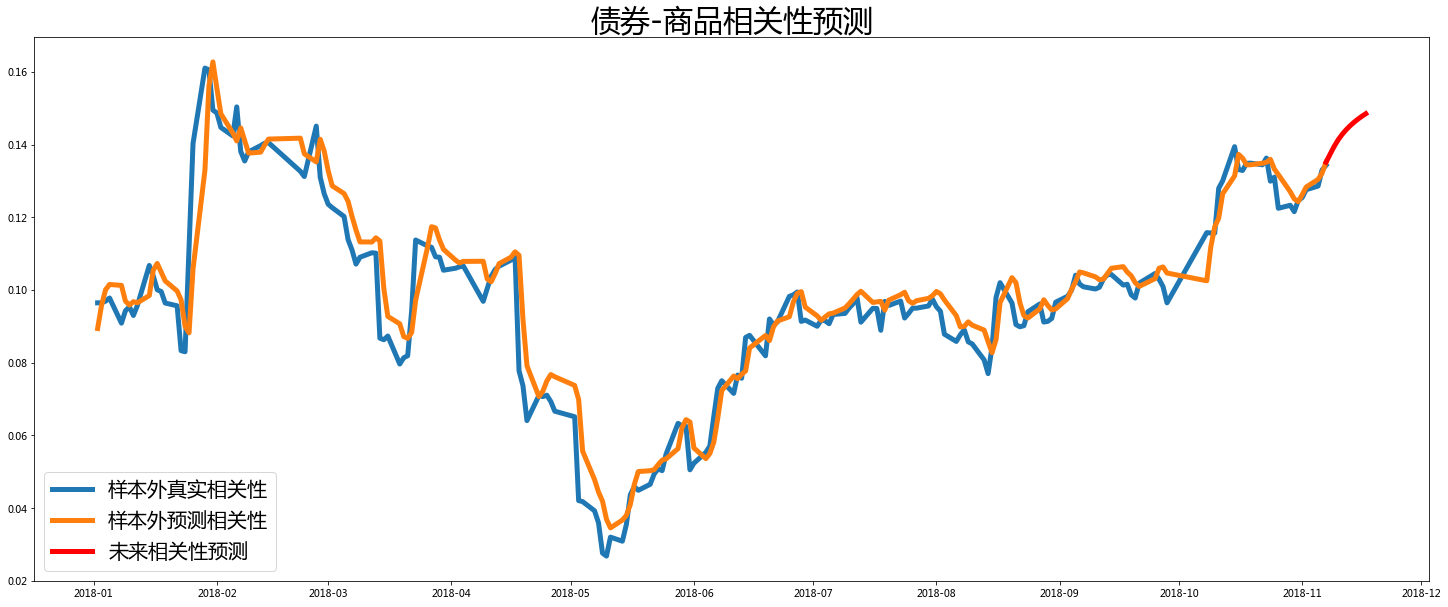

In [173]:
# plot the results
fig, ax = plt.subplots(figsize=(25, 10))
x = true_values + test_mean.reshape(-1)
y = predicted_values + test_mean.reshape(-1)
ax.plot(x[x.index >= '2018-01-01'], label=u'样本外真实相关性', linewidth=5)
ax.plot(y[y.index >= '2018-01-01'], label=u'样本外预测相关性', linewidth=5)
ax.plot(fut_seq, label=u'未来相关性预测', color='red', linewidth=5)
# ax.set_title(u'股票-债券相关性预测', fontsize=30)
# ax.set_title(u'股票-商品相关性预测', fontsize=30)
ax.set_title(u'债券-商品相关性预测', fontsize=30)
ax.legend(fontsize=20)

In [174]:
# fig.savefig('../pic/volatility_prediction_stock_bond.png', dpi=200, bbox_inches='tight')
# fig.savefig('../pic/volatility_prediction_stock_commodity.png', dpi=200, bbox_inches='tight')
fig.savefig('../pic/volatility_prediction_bond_commodity.png', dpi=200, bbox_inches='tight')